# Project Elec

## I Load and preprocess dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/LD2011_2014.txt',sep = ';', low_memory=False)
df = df.replace(r",", ".",regex = True) 
df = df.rename(columns = {"Unnamed: 0": "date"})

data = df.drop("date", axis = 1).astype("float")
data["date"] = df.date.apply(lambda x: x.split(' ')[0])
data['date'] = pd.to_datetime(data.date)
data = data.groupby('date').agg('sum').reset_index()

In [3]:
data.tail()

,date,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
1457,2014-12-28,227.157360,2131.578947,151.172893,14327.235772,6776.829268,20122.023810,429.621255,25255.892256,5118.881119,...,28815.132049,3272100.0,220721.518987,257477.272727,8169.491525,552.369807,45914.837577,4405.676127,66135.630499,1.553189e+06
1458,2014-12-29,248.730964,2212.660028,160.729800,14067.073171,7198.780488,22824.404762,550.593556,30286.195286,6697.552448,...,28825.124911,3109100.0,206852.320675,269090.909091,8438.070404,1153.891164,53928.884987,12914.858097,73882.697947,1.806486e+06
1459,2014-12-30,232.233503,2205.547653,165.073849,14290.650407,7189.024390,23880.952381,586.772188,30909.090909,6487.762238,...,28488.222698,2904300.0,204126.582278,263613.636364,10615.384615,892.334699,56334.503951,15996.661102,73950.146628,1.867568e+06
1460,2014-12-31,229.695431,2273.115220,166.811468,14006.097561,7023.170732,23511.904762,690.785755,28700.336700,6211.538462,...,26970.735189,2748800.0,162556.962025,215886.363636,7415.906128,530.134582,50259.877085,13245.409015,70416.422287,1.365892e+06
1461,2015-01-01,2.538071,19.914651,1.737619,178.861789,84.146341,279.761905,10.175240,249.158249,62.937063,...,188.436831,27800.0,1409.282700,954.545455,27.379400,4.095963,628.621598,131.886477,673.020528,7.135135e+03


## II Clustering

In [4]:
import numpy as np
from sklearn.cluster import KMeans, SpectralClustering
import matplotlib.pyplot as plt

# create a new dataframe without date to do spectral clustering 
df_day = data.copy().T
df_day = df_day.drop('date').fillna(0)
df_day.columns = list(np.arange(1,1463,1))

# spectral clustering
n_clusters = 3
sc = SpectralClustering(n_clusters=n_clusters, affinity = 'nearest_neighbors',random_state=32)
sc.fit(df_day)
labels = sc.labels_ # labels should have 370 data point with value 0, 1, 2

Text(0, 0.5, 'Count')

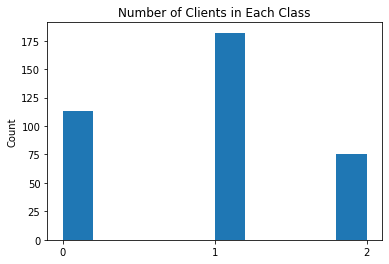

In [5]:
plt.hist(labels)
plt.xticks(range(n_clusters),[str(i) for i in range(n_clusters)])
plt.title('Number of Clients in Each Class')
plt.ylabel('Count')

In [6]:
clusters = []

for c in range(n_clusters):
    good_cols = [f'MT_{i+1:03d}' for i in range(len(labels)) if labels[i]==c]
    df_clustered = df_day.T[good_cols]
    # y: calculate the sum
    y = df_clustered.sum(axis = 1)
    # people: number of clients
    people = (df_clustered > 0).sum(axis = 1).astype(int)
    df_clustered_2 = pd.DataFrame({"date" : data['date'], "people": people, "y" : y}).dropna()
    clusters.append(df_clustered_2.set_index('date'))

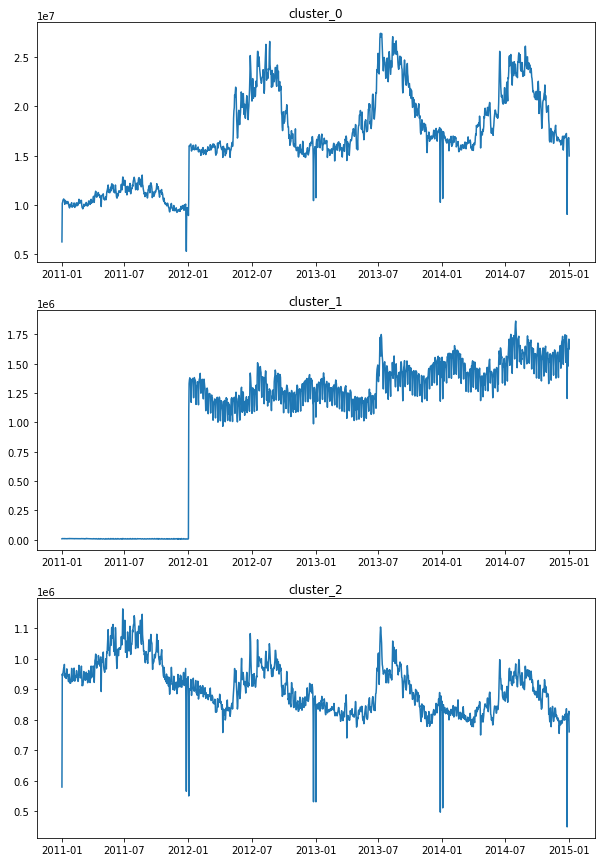

In [7]:
# plot the ts
fig, axs = plt.subplots(n_clusters, 1, figsize = (10, 5* n_clusters))
for c in range(n_clusters):
    axs[c].plot(clusters[c]['y'])
    axs[c].set(title = f"cluster_{c}")

## III Add exogenuous variables

In [8]:
# month number
for c in range(n_clusters):
    temp = clusters[c].copy()
    temp['month'] = [temp.index[i].month for i in range(len(temp))]
    temp = pd.get_dummies(temp['month'])
    clusters[c] = clusters[c].join(temp)

In [9]:
# week day
for c in range(n_clusters):
    temp = clusters[c].copy()
    temp['weekday'] = [temp.index[i].strftime('%A') for i in range(len(temp))]
    temp = pd.get_dummies(temp['weekday'])

    clusters[c] = clusters[c].join(temp)
    clusters[c] = clusters[c].reset_index()

    clusters[c] = clusters[c].rename(columns={'date':'ds'})
    clusters[c] = clusters[c].rename(columns={i:str(i) for i in range(1,13)})

In [10]:
# time difference
for c in range(n_clusters):
    clusters[c]['t'] = (clusters[c]['ds'] - min(clusters[c]['ds'])).astype('timedelta64[D]').astype(int)

In [11]:
clusters[0]

,ds,people,y,1,2,3,4,5,6,7,...,11,12,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,t
0,2011-01-02,80.0,6.264274e+06,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2011-01-03,80.0,1.018043e+07,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,2011-01-04,80.0,1.029498e+07,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,2
3,2011-01-05,80.0,1.050543e+07,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3
4,2011-01-06,80.0,1.054921e+07,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2014-12-28,112.0,1.665274e+07,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1456
1457,2014-12-29,112.0,1.664776e+07,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1457
1458,2014-12-30,112.0,1.683493e+07,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1458
1459,2014-12-31,112.0,1.678900e+07,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1459


## IV Models

In [15]:
! #pip install pmdarima

In [16]:
from sklearn.linear_model import ElasticNet
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
import pmdarima as pm

from sklearn.metrics import mean_absolute_percentage_error

def compute_mape(real, predicted):
    mape = mean_absolute_percentage_error(real, predicted)
    return mape


class LinModel:
    
    def __init__(self, alpha=0, l1_ratio=0):
        self.model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
        
    def fit(self, train):
        X_train, y_train = train.drop(['y','ds'], axis=1), train['y']
        #X_train = PolynomialFeatures(degree=2, interaction_only=True).fit_transform(X_train)
        self.model = self.model.fit(X_train, y_train)
    
    def predict(self, test):
        X_test = test.drop(['y','ds'], axis=1)
        #X_test = PolynomialFeatures(degree=2, interaction_only=True).fit_transform(X_test)
        preds = self.model.predict(X_test)
        
        return preds

class XGBModel:
    
    def __init__(self, n_estimators=100, max_depth=5):
        self.model = XGBRegressor(n_estimators = n_estimators, max_depth = max_depth)
        
    def fit(self, train):
        X_train, y_train = train.drop(['y','ds'], axis=1), train['y']
        self.model = self.model.fit(X_train, y_train)
    
    def predict(self, test):
        X_test = test.drop(['y','ds'], axis=1)
        preds = self.model.predict(X_test)
        
        return preds
    
class RFModel:
    
    def __init__(self, n_estimators=100, max_depth=5):
        self.model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
        
    def fit(self, train):
        X_train, y_train = train.drop(['y','ds'], axis=1), train['y']
        self.model = self.model.fit(X_train, y_train)
    
    def predict(self, test):
        X_test = test.drop(['y','ds'], axis=1)
        preds = self.model.predict(X_test)
        
        return preds


class ProphetModel:
    
    def __init__(self, changepoint_prior_scale=None, n_changepoints=None):
        self.model = Prophet()
        
        if changepoint_prior_scale:
            self.model.changepoint_prior_scale = changepoint_prior_scale
        if n_changepoints:
            self.model.n_changepoints = n_changepoints
        
        
        for k in range(1,13):
            self.model.add_regressor(str(k))
        for day in ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']:
            self.model.add_regressor(day)    

        #self.model.changepoint_prior_scale = i
        #self.model.n_changepoints = j
        
    def fit(self, train):
        self.train = train
        self.model = self.model.fit(train)
    
    def predict(self, test):
        future = self.model.make_future_dataframe(periods=(max(test['ds'])-max(self.train['ds'])).days)
        
        for k in range(1,13):
            future[str(k)] = [1 if future['ds'][l].month==k else 0 for l in range(len(future))]
        for day in ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']:
            future[day] = [1 if future['ds'][l].strftime('%A')==day else 0 for l in range(len(future))]  
            
        forecast = self.model.predict(future)
        preds = forecast[forecast['ds'].isin(test['ds'])]['yhat']
        
        return preds
    

################################### CAN BE UPGRADED IN SARIMAX #########################################
class SARIMAModel:
    
    def __init__(self, start_p=1, start_q=1, max_p=10, max_q=10, start_P=0, start_Q=0):
        self.start_p, self.start_q, self.max_p, self.max_q, self.start_P, self.start_Q = start_p, start_q, max_p, max_q, start_P, start_Q
        
    def fit(self, train):
        self.model = pm.auto_arima(
            train['y'], 
            start_p=self.start_p,
            start_q=self.start_q,
            max_p=self.max_p,
            max_q=self.max_q,
            m=7,
            start_P=self.start_P,
            start_Q=self.start_Q,
            #trace=True,
            stepwise=False,
            n_jobs=-1)
        
    def predict(self, test):
        m = self.model
        return(m.predict(n_periods=len(test)))

In [17]:
best_models = []

for c in range(n_clusters):
    
    # split test-train
    train, test = clusters[c].iloc[:int(len(clusters[c])*0.7)], clusters[c].iloc[int(len(clusters[c])*0.7)+1:]
    
    mapes, models = {}, {}
    
    # try linear
    m=LinModel()
    m.fit(train)
    preds=m.predict(test)
    mapes['linear']=compute_mape(test['y'], preds)
    models['linear']=m
    
    # try xgb
    m=XGBModel()
    m.fit(train)
    preds=m.predict(test)
    mapes['xgboost']=compute_mape(test['y'], preds)
    models['xgboost']=m
    
    
    # try prophet
    m=ProphetModel()
    m.fit(train)
    preds=m.predict(test)
    mapes['prophet']=compute_mape(test['y'], preds)
    models['prophet']=m
    
    # try sarimax
    m=SARIMAModel()
    m.fit(train)
    preds=m.predict(test)
    mapes['sarima']=compute_mape(test['y'], preds)
    models['sarima']=m
    
    # select best
    print(mapes)
    best_model = min(mapes, key=mapes.get)
    best_models.append(models[best_model])
    

<ipython-input-16-87c7084503bb>:23: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model = self.model.fit(X_train, y_train)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.281e+15, tolerance: 2.395e+12 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[04:31:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgcpcc8um/b4514p55.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgcpcc8um/xnd9fcs5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66873', 'data', 'file=/tmp/tmpgcpcc8um/b4514p55.json', 'init=/tmp/tmpgcpcc8um/xnd9fcs5.json', 'output', 'file=/tmp/tmpgcpcc8um/prophet_model731y_77h/prophet_model-20221217043110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:31:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:31:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{'linear': 0.058985905769323686, 'xgboost': 0.1457353044750475, 'prophet': 0.31187154336972833, 'sarima': 0.5349307425679081}
[04:32:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


<ipython-input-16-87c7084503bb>:23: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model = self.model.fit(X_train, y_train)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.432e+12, tolerance: 3.819e+10 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
INFO:prophet:Disabling dai

{'linear': 0.04464000868555261, 'xgboost': 0.07855528896821497, 'prophet': 0.5408241278424216, 'sarima': 3.2213777821574126}
[04:34:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


<ipython-input-16-87c7084503bb>:23: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model = self.model.fit(X_train, y_train)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.534e+11, tolerance: 6.868e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
INFO:prophet:Disabling dai

{'linear': 0.07775503259543756, 'xgboost': 0.06679443198545076, 'prophet': 0.0386388274330477, 'sarima': 0.06894766861107686}


## V Predictions

Best model for group0 is <__main__.LinModel object at 0x7f9e41518490>.


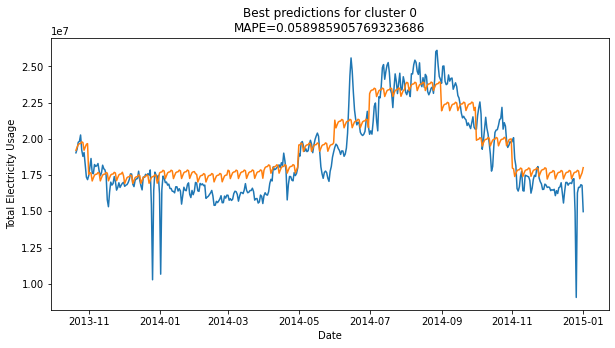

Best model for group1 is <__main__.LinModel object at 0x7f9e3a6895b0>.


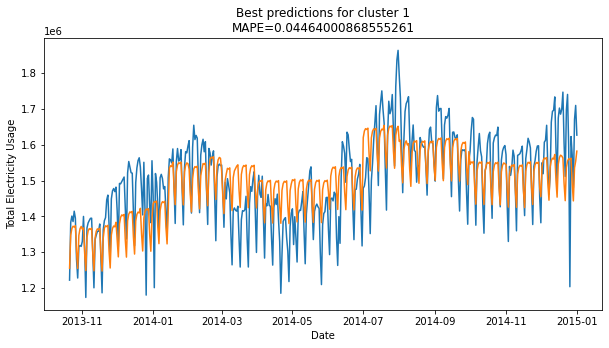

Best model for group2 is <__main__.ProphetModel object at 0x7f9e3bf416d0>.


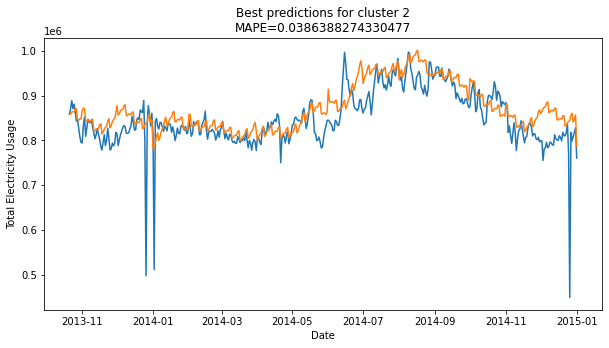

In [18]:
for c in range(n_clusters):
    
    m = best_models[c]
    print(f"Best model for group{c} is {m}.")
    test = clusters[c].iloc[int(len(clusters[c])*0.7)+1:]
    preds = m.predict(test)
    
    plt.figure(figsize=(10, 5))
    plt.plot(test['ds'], test['y'], label='real values')
    plt.plot(test['ds'], preds, label='test predictions')

    plt.xlabel('Date')
    plt.ylabel('Total Electricity Usage')
    plt.title(f'Best predictions for cluster {c}\nMAPE={compute_mape(test["y"], preds)}')
    plt.show()

In [19]:
inv_1 = range(int(len(clusters[c])*0.7)+1, int(len(clusters[c])*0.8))
inv_2 = range(int(len(clusters[c])*0.8)+1, int(len(clusters[c])*0.9))
inv_3 = range(int(len(clusters[c])*0.9)+1, len(clusters[c]))

inv = [inv_1, inv_2, inv_3]

x = np.empty((3, 3))

for c in range(n_clusters):
  m = best_models[c]
  print(f"Best model for group{c} is {m}.")
  for i in range(len(inv)):
    test = clusters[c].iloc[inv[i]]
    preds = m.predict(test)
    x[c, i] = round(compute_mape(test["y"], preds),3) * 100 # change the mape in to %

index = pd.Index(['group1', 'group2', 'group3'])
pd.DataFrame(x, columns=['First 4 months', 'Second 4 months', "Third 4 months"]).set_index(index)

Best model for group0 is <__main__.LinModel object at 0x7f9e41518490>.
Best model for group1 is <__main__.LinModel object at 0x7f9e3a6895b0>.
Best model for group2 is <__main__.ProphetModel object at 0x7f9e3bf416d0>.


,First 4 months,Second 4 months,Third 4 months
group1,6.3,5.6,5.8
group2,4.1,5.7,3.5
group3,3.5,3.5,4.6
